In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

In [2]:
#                 **************    B1203+645     **************

fits_filename = ('/Users/orion/phd_research/blr_fit/1203+645_spec-6974-56442-0571.fits')     
hdul = fits.open(fits_filename)
hdul.info()

Filename: /Users/orion/phd_research/blr_fit/1203+645_spec-6974-56442-0571.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     131   ()      
  1  COADD         1 BinTableHDU     26   4591R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    474   1R x 232C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 6A, 6A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E,

In [3]:
spec=hdul[0].data
header=hdul[0].header

In [5]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4591 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [6]:
flux = hdul[1].data['flux']
lam = 10**(hdul[1].data['loglam'])
#by default, wavelength scale is in log, so take anti-log
    
units_flux = hdul[0].header['bunit']
print(units_flux)

1E-17 erg/cm^2/s/Ang


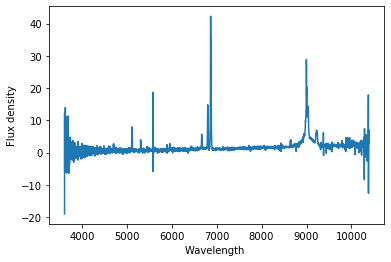

In [7]:
plt.plot(lam, flux)
#plt.ylim(-1,15)
#plt.xlim(8500,10000)
plt.xlabel('Wavelength ')
plt.ylabel('Flux density')
plt.show()

In [8]:
flux[np.isnan(flux)] = 1e-15
flux[flux<-10] = 1e-15

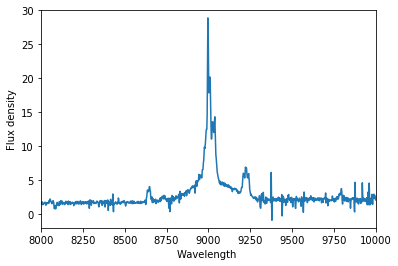

In [9]:
plt.plot(lam, flux)
plt.ylim(-2,30)
plt.xlim(8000,10000)
plt.xlabel('Wavelength ')
plt.ylabel('Flux density')
plt.show()

In [10]:
# De-redshifting spectrum 

#z = 0.371598   #sdss spectroscopic   
#z = 0.37171 or 0.372094   # both from NED

z = 0.371598
k = 1+z
k

1.371598

In [11]:
# ** Needs continuum subtraction 

select_cont = (lam>8200) & (lam<8550)
continuum = flux[select_cont]
mean_cont = np.mean(continuum)
mean_cont

1.6965244

In [12]:
flux = flux - mean_cont

[2632.529  2633.1348 2633.742  ... 7571.344  7573.091  7574.8364]


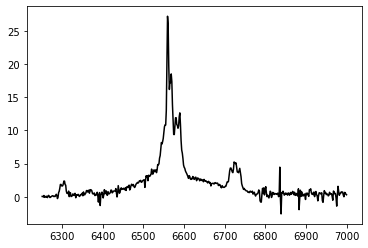

In [13]:
select = (lam/k>6250) & (lam/k<7000)
wave = (lam/k)[select]
spec = flux[select]

print (lam/k)
plt.plot(wave,spec,'k-')

In [14]:
# Rest wavelengths of the lines (** should be in VACUUM for SDSS spectra)

#NIIa = 6549.86
#NIIb = 6585.27
#Halpha = 6564.614
#SIIa = 6718.29
#SIIb = 6732.68

def redshift(vel):
    return vel/300000.0 

def line_width(vel_sigma,rest_line,inst_res_fwhm=0.0): 
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2) 

def gauss(wave_range,amplitude,vel,vel_sigma,rest_w):
    line = (amplitude)*exp(-(wave_range-(rest_w*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_w))**2))
    return line

def full_gauss(wave_range,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c):#amp_HaBS
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6718.29)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6732.68)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6564.614)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6585.27)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6549.86)
    cont = (wave_range/1000.0)*m+c
    return Ha + Ha_broad + NII_6548 + NII_6583 + SII_6716 + SII_6730 + cont  

[ 1.69224236e+01  7.86422297e+00  2.94221760e+00  3.72106768e+00
 -7.50631127e+01  3.08555919e+02  3.83566915e+00  3.50723004e+02
  3.07301930e+03 -1.92221619e-02  5.59471225e-01]


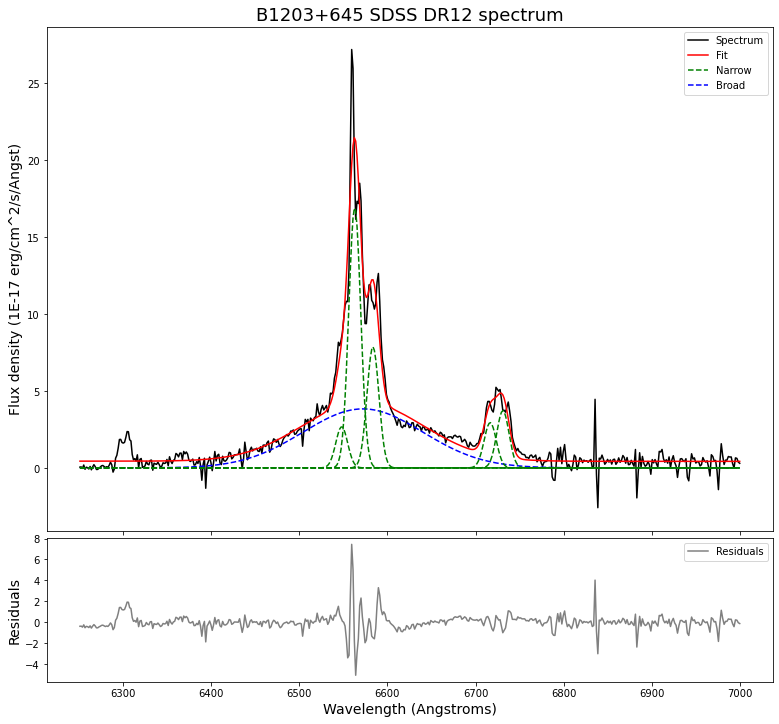

In [17]:
#popt, pcov = curve_fit(func, x, y, p0=[<initial guesses>])
#p0 = [amp_Ha_narrow , amp_NII6585 , amp_SII6716 , amp_SII6730 , vel_narrow , vel_sigma_narrow , amp_Ha_broad , 
#vel_Ha_broad , vel_sigma_Ha_broad , m , c]
#constraint: same linewidths for all narrow components

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

popt_full_fit,pcov_full_fit = curve_fit(full_gauss, wave, spec, p0=[30, 20, 10, 5, 0, 100, 5, 0, 200, 0, 0])                                                  
print (popt_full_fit)

yfit = full_gauss(wave, *popt_full_fit)
(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = popt_full_fit

ax1.plot(wave, spec, 'k-', label='Spectrum')
ax1.plot(wave, yfit,'r-',label='Fit')
ax1.plot(wave, gauss(wave,amp_Ha,vel,vel_sigma,6564.614), 'g-', linestyle='--', label='Narrow')
ax1.plot(wave, gauss(wave,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614), 'b-', linestyle='--', label='Broad')
ax1.plot(wave, gauss(wave,amp_NII6585,vel,vel_sigma,6585.27), 'g-', linestyle='--')
ax1.plot(wave, (0.34)*gauss(wave,amp_NII6585,vel,vel_sigma,6549.86), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6716,vel,vel_sigma,6718.29), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6730,vel,vel_sigma,6732.68), 'g-', linestyle='--')
residuals = spec - yfit
ax2.plot(wave, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
ax1.set_title('B1203+645 SDSS DR12 spectrum', {'fontsize': 18})
ax1.set_ylabel('Flux density (1E-17 erg/cm^2/s/Angst)', {'fontsize': 14})
ax2.set_ylabel('Residuals', {'fontsize': 14})
ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.legend()
ax2.legend()
plt.show()

In [18]:
perr_full_fit = np.sqrt(np.diag(pcov_full_fit))
perr_full_fit

array([  0.4043721 ,   0.40429684,   0.33858098,   0.3291115 ,
         8.64473622,   7.29823621,   0.1900591 , 113.06688097,
       151.72994352,   0.18417472,   1.2282084 ])

In [19]:
# component-flux computations

sigma_eff_HaB = line_width(vel_sigma_HaB,6564.614)
broadline_flux = amp_HaB*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_HaB))#*(10**(-17))
print('broad:', broadline_flux, '(x1E-17)')

sigma_eff_Ha = line_width(vel_sigma,6564.614)
narrowline_flux = amp_Ha*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Ha))#*(10**(-17))
print('narrow:', narrowline_flux, '(x1E-17)')

broad: 653.2146146786791 (x1E-17)
narrow: 286.695731896076 (x1E-17)


In [20]:
#  Constructing error-spectrum to use fitting function 'leastsq'

In [21]:
s = np.mean(spec)
n = np.std(spec)

snr = (s/n)

err_spec = np.sqrt(spec/s)*snr   # (datacube / mean continuum)^1/2  =>  error cube 
err_spec

/Users/orion/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


array([0.09451762, 0.10545027,        nan, 0.17948563,        nan,
       0.08850901, 0.05176866,        nan, 0.12568437,        nan,
       0.10639203, 0.1899857 , 0.12004951,        nan,        nan,
              nan, 0.09541877, 0.15291446, 0.16503708, 0.12334206,
       0.06730422, 0.11759076, 0.07924832, 0.17225638, 0.25255457,
       0.18618724,        nan,        nan, 0.32872933, 0.3751738 ,
       0.46661592, 0.5625225 , 0.5635819 , 0.53175074, 0.52542746,
       0.53340435, 0.58120716, 0.6361873 , 0.6344352 , 0.56006986,
       0.5478195 , 0.38603628, 0.29915333, 0.32221535, 0.27547935,
       0.3820198 , 0.05341073, 0.3085728 , 0.32400683, 0.07494784,
       0.10984051, 0.1514136 , 0.26846576, 0.20696735, 0.18523653,
       0.28907818, 0.29463118,        nan, 0.22916684, 0.21017537,
       0.20007521, 0.25148252, 0.19462237, 0.08569375, 0.13946529,
       0.23899621, 0.22250347, 0.23409124, 0.30691293, 0.15728684,
       0.35230178, 0.27430537, 0.22005977, 0.28853425, 0.30791

In [ ]:
from astropy.convolution import Gaussian1DKernel, convolve

gaussG = Gaussian1DKernel(stddev=2)
err_spec_temp = convolve(err_spec, gaussG)
#err_spec_temp

In [24]:
select_cont2 = (wave>6800)&(wave<7000)

flux_cont = np.std(spec[select_cont2])
flux_err = np.mean(err_spec_temp[select_cont2])

b = flux_cont/flux_err
print (b)

err_spec = b*err_spec_temp
err_spec

2.3202224


array([0.13606478, 0.19092967, 0.23886052, 0.26214266, 0.2547601 ,
       0.23425767, 0.22291242, 0.23128521, 0.25641364, 0.28550556,
       0.30730626, 0.31894213, 0.3211413 , 0.3140817 , 0.3019906 ,
       0.2967404 , 0.29894027, 0.29924703, 0.29279783, 0.28205132,
       0.27653408, 0.28751874, 0.31901154, 0.36531845, 0.42029387,
       0.49087834, 0.59811145, 0.7414831 , 0.87936425, 0.99021906,
       1.0813214 , 1.1558628 , 1.2101542 , 1.2457561 , 1.2732825 ,
       1.3023722 , 1.329997  , 1.3396331 , 1.3116909 , 1.2366722 ,
       1.1222965 , 0.99096686, 0.8680712 , 0.7681412 , 0.69075686,
       0.62880033, 0.576398  , 0.52827686, 0.48072118, 0.43947443,
       0.41919127, 0.42826962, 0.45933804, 0.4979375 , 0.53407985,
       0.5618565 , 0.5737926 , 0.5641789 , 0.5392146 , 0.5115193 ,
       0.48496944, 0.45712015, 0.43105718, 0.4185056 , 0.4299842 ,
       0.4634438 , 0.505723  , 0.5440823 , 0.57385314, 0.59658784,
       0.61527675, 0.6341056 , 0.66027117, 0.7000625 , 0.75122

In [ ]:
plt.plot(wave,err_spec,'k-')

In [26]:
def gauss(wave_range,amplitude,vel,vel_sigma,rest_w):
    line = (amplitude)*exp(-(wave_range-(rest_w*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_w))**2))
    return line

def full_gauss_residual(params,wave_range,data,error):
    (amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = params
    
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6718.29)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6732.68)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6564.614)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6585.27)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6549.86)    
    cont = (wave_range/1000.0)*m+c
    
    return ((Ha+Ha_broad+NII_6548+NII_6583+SII_6716+SII_6730+cont)-data)/error


In [27]:
#p0 = [amp_Ha_narrow , amp_NII6585 , amp_SII6716 , amp_SII6730 , vel_narrow , vel_sigma_narrow , amp_Ha_broad , 
#vel_Ha_broad , vel_sigma_Ha_broad , m , c]

from scipy.optimize import leastsq
from numpy import asarray as ar,exp

x0 = [30, 20, 10, 5, 0, 100, 5, 0, 200, 0, 0]

pfit, pcov, info, msg, success = leastsq(full_gauss_residual, x0, args=(wave, spec, err_spec), 
                                         full_output=1, maxfev=10000000)

print(pfit)
print('number of function calls =', info['nfev'])

[ 1.58235909e+01  8.02518494e+00  3.23717636e+00  3.27085602e+00
  0.00000000e+00  3.34590827e+02  3.60708411e+00  0.00000000e+00
  3.40510777e+03  4.29647492e-01 -2.58524648e+00]
number of function calls = 126


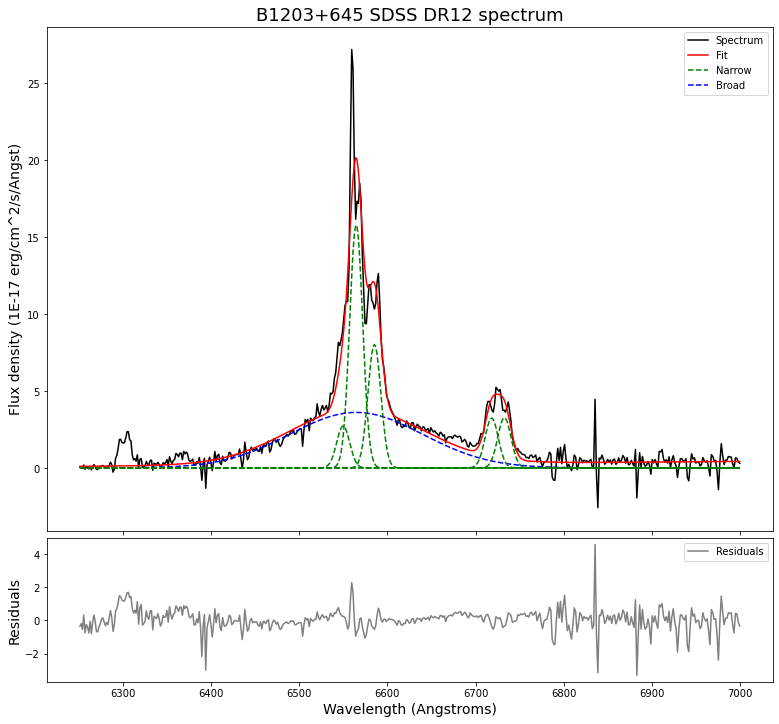

In [28]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = pfit

yfit = full_gauss(wave, *pfit)

ax1.plot(wave, spec, 'k-', label='Spectrum')
ax1.plot(wave, yfit,'r-',label='Fit')
ax1.plot(wave, gauss(wave,amp_Ha,vel,vel_sigma,6564.614), 'g-', linestyle='--', label='Narrow')
ax1.plot(wave, gauss(wave,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614), 'b-', linestyle='--', label='Broad')
ax1.plot(wave, gauss(wave,amp_NII6585,vel,vel_sigma,6585.27), 'g-', linestyle='--')
ax1.plot(wave, (0.34)*gauss(wave,amp_NII6585,vel,vel_sigma,6549.86), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6716,vel,vel_sigma,6718.29), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6730,vel,vel_sigma,6732.68), 'g-', linestyle='--')
residuals = (spec - yfit)/err_spec
ax2.plot(wave, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
ax1.set_title('B1203+645 SDSS DR12 spectrum', {'fontsize': 18})
ax1.set_ylabel('Flux density (1E-17 erg/cm^2/s/Angst)', {'fontsize': 14})
ax2.set_ylabel('Residuals', {'fontsize': 14})
ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
#uncertainty in leastsq fit

if (len(spec) > len(x0)) and pcov is not None:
    s_sq = (full_gauss_residual(pfit, wave, spec, err_spec)**2).sum()/(len(spec)-len(x0))
    pcov = pcov * s_sq

else:
    pcov = np.inf
        
error = [] 
for i in range(len(pfit)):
    try:
        error.append(np.absolute(pcov[i][i])**0.5)
    except:
        error.append(0.00)

perr_leastsq = np.array(error) 
#print(perr_leastsq)

In [31]:
# component-flux computations

sigma_eff_HaB = line_width(vel_sigma_HaB,6564.614)
broadline_flux = amp_HaB*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_HaB))#*(10**(-17))
print('broad:', broadline_flux, '(x1E-17)')

sigma_eff_Ha = line_width(vel_sigma,6564.614)
narrowline_flux = amp_Ha*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Ha))#*(10**(-17))
print('narrow:', narrowline_flux, '(x1E-17)')

broad: 681.4321068800119 (x1E-17)
narrow: 290.7244727379413 (x1E-17)
